# AML Homework 2

### Author: Yelene Cisse
### Date: 10/22/2025
### Update: 11/04/2025
### Data: https://archive.ics.uci.edu/dataset/222/bank+marketing (45211 rows × 17 columns)
### Purpose of models:  

Predict whether a customer will subscribe to a term deposit based on demographic and
campaign features.

### Learning Objective:

Compare boosting techniques and their effect on model performance.


#### Runtime: ~11 minutes

In [1]:
# Data Complete Dictionary from UCI:
# Bank client data

"""
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   # related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   # other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
   # social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric) 
  (https://www.euribor-rates.eu/en/ -  Euribor = Euro Interbank Offered Rate. The Euribor rates are based on the average interest rates at which a large panel of European banks borrow funds from one another.)
  20 - nr.employed: number of employees - quarterly indicator (numeric)

  Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")
"""

'\n   1 - age (numeric)\n   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")\n   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)\n   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")\n   5 - default: has credit in default? (categorical: "no","yes","unknown")\n   6 - housing: has housing loan? (categorical: "no","yes","unknown")\n   7 - loan: has personal loan? (categorical: "no","yes","unknown")\n   # related with the last contact of the current campaign:\n   8 - contact: contact communication type (categorical: "cellular","telephone") \n   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")\n  10 - day_of_week: last contact day of the week (categ

# Set up
Define useful functions.
Import necessary libraries and dataset.

In [2]:
# Import libraries

# For data manipulations
import pandas as pd
import numpy as np
import datetime
import scipy

# For feature engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# For model training
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier
)
import xgboost as xgb
from xgboost import cv, DMatrix

from sklearn.model_selection import (train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve)
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score, log_loss,
    roc_curve, auc, precision_recall_curve, roc_auc_score
)

# For visualization
from seaborn import heatmap
from matplotlib import pyplot as plt

# For export
import openpyxl
import xlsxwriter

# For data import:
from ucimlrepo import fetch_ucirepo
pd.set_option('display.max_columns', None)

In [3]:
# For data exploration
def data_summary(df, cat_cols, num_cols, describe_pts=[0.1, .2,.25,.5, .75, .9, .95, .99]):
    print("Data shape: ", df.shape)
    print("Data columns: ", df.columns)

    # Get hit rates for variables in the dataset, evaluate missing values proportions
    hr = df.notnull().mean().reset_index().rename(columns={'index':'variable',0:'hit_rate'}) 

    # Get data types
    df_types = df.dtypes.reset_index().rename(columns={'index':'variable',0:'data_type'}) 

    # Put info in same data add
    variable_summary = pd.merge(df_types, hr, on=['variable'], how='left', suffixes=('','_hr'))

    # Get value counts for categorical variables
    cat_vars_summary = pd.DataFrame(columns=['variable_name','unique_values','counts'])
    for col in cat_cols:
        new_counts = df[col].value_counts(dropna=False).rename_axis('unique_values').to_frame('counts').reset_index()
        new_counts.insert(loc=0, column='variable_name', value=col)
        cat_vars_summary = pd.concat([cat_vars_summary, new_counts], ignore_index = True)
        
    cont_vars_summary = df[num_cols].describe(describe_pts).reset_index().rename(columns={'index':'stats'}) 

    # Get correlation matrix for continuous variables
    df_corr = df[num_cols].corr()

    return variable_summary, cat_vars_summary, cont_vars_summary, df_corr


# For model evaluation - plotting confusion matrix with seaborn
def plot_confusion_matrix(cm, title, color="viridis",  annotation=True):
    fig, ax = plt.subplots()
    ax = heatmap(cm, annot=annotation, cmap=color,xticklabels=['yes','no'], yticklabels=['yes','no'], fmt='g')
    ax.set(xlabel="Predicted Value", ylabel="True Value")
    ax.set_title(title)
    plt.show()
    return fig

def plot_roc_curve(y_true, y_pred_proba, model_version=None):
    plt.close()
    fpr, tpr, threshold = roc_curve(y_true, y_pred_proba)
    area = roc_auc_score(y_true, y_pred_proba)
    
    print("ROC AUC score: ", area)
    
    fig, ax = plt.subplots()
    plt.grid(color='grey', linestyle='--')
    plt.title('ROC curves: ' + str(model_version))
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
    plt.plot([0, 0, 1], [0, 1, 1], color='green', linestyle='--', label='Perfect ROC')
    plt.plot(fpr, tpr, color='orange', linewidth=2, label='ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(['Baseline (AUC = 0.5)', 'Perfect (AUC = 1.0)', 
                'ROC (AUC = ' + str(round(area, 4)) + ')'])
    plt.close()
    return fig

def plot_auc_curve(y_true, y_pred, model_version=None,cm=None):
    plt.close()
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    area = auc(recall, precision)
    print("AUCPR: ", area)
    baseline = np.sum(y_true) / len(y_true)

    fig, ax = plt.subplots()
    plt.grid(color='grey', linestyle='--')
    plt.title('Precision-Recall curve: ' + model_version)
    plt.plot([0, 1], [baseline, baseline], color='blue', label='Baseline AUCPR')
    plt.plot([1, 1, 0],[0, 1, 1], color='green', label='Perfect AUCPR')
    plt.plot(recall, precision, color='orange', label='AUCPR')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(['Baseline = '+ str(round(baseline,4)), 'Perfect AUCPR = 1', 'AUCPR (area = ' + str(round(area,4))])
    plt.close()
    return area, fig


# Plot feature importance
def plot_feature_importance(importance_df, model_name, top_n=20):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = importance_df.head(top_n)
    
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.tight_layout()
    ax.invert_yaxis()
    return fig

def plot_validation_curve(param_range, train_scores, test_scores, model_version='', ylabel='Accuracy',xlabel='Max Depth'):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    # Compute means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # Plot learning curve
    plt.plot(param_range, train_mean, label="Training score", marker='o')
    plt.plot(param_range, test_mean, label="Cross-validation score", marker='o')
    plt.title("Validation Curve: " + model_version + xlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid(True)
    plt.close()
    return fig

# The following function was taken from class Colab example
def pos_ratio(a):
    return float(a.mean())

In [4]:
# Set date and path for file saving
date = datetime.datetime.now().strftime("%m_%d_%Y")
folder_path = '/Users/yelene/Desktop/Grad school/Columbia/Classes/Fall 2025/AML/'
plot_path = folder_path + 'plots/'

# Set up EDA output
eda_filename = "AML_HW2_EDA_results_" + date + '.xlsx'
save_eda_results = False
eda_summary = {}

# Set up model output
version_run = "v1"
result_filename = "AML_HW2_model_results_" + version_run + "_" + date  + '.xlsx'
results_summary = {}


In [5]:
# Import dataset

# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# Using full bank additional dataset
df = pd.read_csv('/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/bank-additional-full-import.csv')

# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Data Cleaning

In [7]:
# Create categorical and continuous lists
cat =  bank_marketing.variables[bank_marketing.variables['type']=="Categorical"]['name'].to_list()
cat = cat + ['default','housing','loan']
# Based on variable dictionary, create different lists for binary and non binary variables
# We will use this distinction later for encoding

# "unknown" category makes this three levels
binary_cat = []
cat = cat + binary_cat + ['day_of_week', 'month']
non_binary_cat = [i for i in cat if i not in binary_cat]

cont =  bank_marketing.variables[bank_marketing.variables['type']=="Integer"]['name'].to_list()
cont = cont + ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m','nr.employed']

# "balance" not in the banking-full dataset, no way to recover it from the regular dataset.
# Remove from continuous list
cont.remove('balance')

print("Categorical features: " , cat, "\nBinary cat features: ", binary_cat, "\nNon-binary cat features: ", non_binary_cat, "\nContinuous features: ", cont)

Categorical features:  ['job', 'marital', 'education', 'contact', 'poutcome', 'default', 'housing', 'loan', 'day_of_week', 'month'] 
Binary cat features:  [] 
Non-binary cat features:  ['job', 'marital', 'education', 'contact', 'poutcome', 'default', 'housing', 'loan', 'day_of_week', 'month'] 
Continuous features:  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


Data exploration

In [8]:
# Get summary statistics
variable_summary, cat_vars_summary, cont_vars_summary, df_corr = data_summary(df, cat + ['y'], cont)

Data shape:  (41188, 21)
Data columns:  Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [9]:
variable_summary

,variable,data_type,hit_rate
0,age,int64,1.0
1,job,object,1.0
2,marital,object,1.0
3,education,object,1.0
4,default,object,1.0
5,housing,object,1.0
6,loan,object,1.0
7,contact,object,1.0
8,month,object,1.0
9,day_of_week,object,1.0


In [10]:
cat_vars_summary

,variable_name,unique_values,counts
0,job,admin.,10422
1,job,blue-collar,9254
2,job,technician,6743
3,job,services,3969
4,job,management,2924
5,job,retired,1720
6,job,entrepreneur,1456
7,job,self-employed,1421
8,job,housemaid,1060
9,job,unemployed,1014


In [11]:
cont_vars_summary

,stats,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
1,mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
2,std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
3,min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
4,10%,28.00000,59.000000,1.000000,999.000000,0.000000,-1.800000,92.893000,-46.200000,1.046000,5076.200000
5,20%,31.00000,89.000000,1.000000,999.000000,0.000000,-1.800000,92.893000,-46.200000,1.299000,5099.100000
6,25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
7,50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
8,75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
9,90%,55.00000,551.000000,5.000000,999.000000,1.000000,1.400000,94.465000,-36.100000,4.964000,5228.100000


In [12]:
df_corr

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [13]:
# For saving EDA results
eda_summary['variable_summary'] = variable_summary
eda_summary['cat_vars_summary'] = cat_vars_summary
eda_summary['cont_vars_summary'] = cont_vars_summary
eda_summary['correlation_matrix'] = df_corr

Save Data Exploration results

In [14]:
if save_eda_results:
    with pd.ExcelWriter(folder_path+eda_filename) as writer:
        for sheet_name, eda_df in eda_summary.items():
            eda_df.to_excel(writer, sheet_name = sheet_name)

    writer.close()

In [15]:
# After reviewing EDA results, few observations can be made:
# Categorical features contain an 'unknown' level, indicating missing

# New hitrate summary for categoricals
for var in cat:
    print(var, 'hit rate: ', str((len(df[var]) - len(df[df[var]=='unknown']))/len(df[var])))

# pdays seems is 90% value=999. Little informational value for model, may drop - will make final decision after feature importance.
print('\n pdays=999 exact % out of pdays: ', df[df['pdays']==999].shape[0]/df.shape[0])

# 999 rate: 96%.

# High correlation between the following features:
# euribor3m, emp.var.rate, and nr.employed (>94%)
# euribor3m, cons.price.idx (=77.5%)

# We will look to feature importance first, then exclude features based on informational value for final model.

# Change target to binary for model training - 'yes' -> 1, 'no' -> 0
df['y'] = np.where(df['y']=='yes',1,0)

job hit rate:  0.9919879576575702
marital hit rate:  0.9980576867048655
education hit rate:  0.9579731960765271
contact hit rate:  1.0
poutcome hit rate:  1.0
default hit rate:  0.7912741575216082
housing hit rate:  0.9759638729727105
loan hit rate:  0.9759638729727105
day_of_week hit rate:  1.0
month hit rate:  1.0

 pdays=999 exact % out of pdays:  0.9632174419733903


Split data before cleaning/transformations

In [16]:
# Split the data into train and test 
# We wil do an 80 - 20 split

# Select all items but target
X = df[[i for i in df.columns if i!='y']]
# Create target df
y = df[['y']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=62, stratify=y)


df_ind = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

for df_name, df_split in df_ind.items():
    print('Data shape - ', df_name , ': ', df_ind[df_name].shape)
    # Reset index for standardization merge
    df_ind[df_name].reset_index(inplace=True)
    df_ind[df_name].drop('index', axis = 1,  inplace=True)
    print(df_ind[df_name].shape)



Data shape -  X_train :  (32950, 20)
(32950, 20)
Data shape -  X_test :  (8238, 20)
(8238, 20)
Data shape -  y_train :  (32950, 1)
(32950, 1)
Data shape -  y_test :  (8238, 1)
(8238, 1)


/var/folders/3g/b4zyzzk94gz7cbv03g735r2m0000gn/T/ipykernel_19691/2887750414.py:113: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(a.mean())


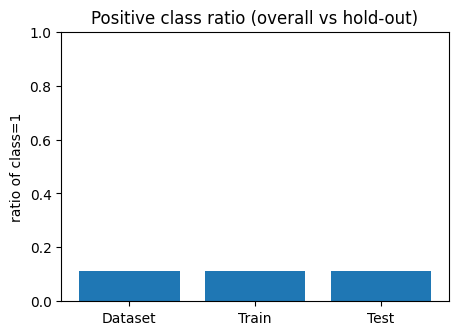

Overall: 0.11265417111780131 | Train: 0.11265553869499241 | Test: 0.11264870114105366


In [17]:
# Make sure we get same ratio with stratified data
labels = ['Dataset', 'Train', 'Test']
ratios = [pos_ratio(y), pos_ratio(y_train), pos_ratio(y_test)]

plt.figure(figsize=(5,3.5))
plt.bar(labels, ratios)
plt.ylim(0,1)
plt.title('Positive class ratio (overall vs hold-out)')
plt.ylabel('ratio of class=1')
plt.show()

print(f'Overall: {pos_ratio(y)} | Train: {pos_ratio(y_train)} | Test: {pos_ratio(y_test)}')


Missing variables handling

In [18]:
df
# bank_full_additional.csv only has categorical missing, already filled with 'unknown' in the dataset.

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


# Feature engineering

In [19]:
# Drop "duration" for realistic model predictions, based on note from data dictionary:
# "Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). 
# Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. 
# Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model."

for df_fill in [X_train, X_test]:
    df_fill.drop('duration', axis=1, inplace=True)
    print(df_fill.shape)

# Update continuous list as well
cont.remove('duration')

(32950, 19)
(8238, 19)


One hot-encoding

In [20]:
# One hot-encoding on categorical variables

# Train encoding
encoded_var_list = []

# The code below is adapted from the "AML_L2_Colab_Demos.ipynb" code example
for var in non_binary_cat:
    print('Variable to encode: ', var)
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    var_ohe_train = ohe.fit_transform(X_train[[var]])
    var_ohe_test = ohe.transform(X_test[[var]])

    print("One-hot categories:", ohe.categories_)
    print("Encoded shape:", var_ohe_train.shape, var_ohe_test.shape)

    encoded_var_train = pd.DataFrame(var_ohe_train, columns=[f"{var}={c}" for c in ohe.categories_[0]])
    encoded_var_test = pd.DataFrame(var_ohe_test, columns=[f"{var}={c}" for c in ohe.categories_[0]])

    encoded_var_list = encoded_var_list + list(encoded_var_train.columns)

    X_train = pd.merge(X_train, encoded_var_train, left_index=True, right_index=True, how='left', suffixes=('','_encod_var'))
    X_test = pd.merge(X_test, encoded_var_test, left_index=True, right_index=True, how='left', suffixes=('','_encod_var'))
    
    print(X_train.shape, X_test.shape)

X_train

Variable to encode:  job
One-hot categories: [array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'], dtype=object)]
Encoded shape: (32950, 12) (8238, 12)
(32950, 31) (8238, 31)
Variable to encode:  marital
One-hot categories: [array(['divorced', 'married', 'single', 'unknown'], dtype=object)]
Encoded shape: (32950, 4) (8238, 4)
(32950, 35) (8238, 35)
Variable to encode:  education
One-hot categories: [array(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
       'professional.course', 'university.degree', 'unknown'],
      dtype=object)]
Encoded shape: (32950, 8) (8238, 8)
(32950, 43) (8238, 43)
Variable to encode:  contact
One-hot categories: [array(['cellular', 'telephone'], dtype=object)]
Encoded shape: (32950, 2) (8238, 2)
(32950, 45) (8238, 45)
Variable to encode:  poutcome
One-hot categories: [array(['failure', 'nonexistent', 'success'], dt

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job=admin.,job=blue-collar,job=entrepreneur,job=housemaid,job=management,job=retired,job=self-employed,job=services,job=student,job=technician,job=unemployed,job=unknown,marital=divorced,marital=married,marital=single,marital=unknown,education=basic.4y,education=basic.6y,education=basic.9y,education=high.school,education=illiterate,education=professional.course,education=university.degree,education=unknown,contact=cellular,contact=telephone,poutcome=failure,poutcome=nonexistent,poutcome=success,default=no,default=unknown,default=yes,housing=no,housing=unknown,housing=yes,loan=no,loan=unknown,loan=yes,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,month=apr,month=aug,month=dec,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep
0,25,services,single,high.school,unknown,no,no,telephone,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39,admin.,single,university.degree,no,yes,yes,cellular,nov,wed,2,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,43,blue-collar,married,basic.9y,unknown,yes,no,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,43,services,married,basic.4y,no,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,35,unemployed,divorced,basic.4y,no,yes,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,41,admin.,married,high.school,no,no,no,telephone,may,fri,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32946,30,admin.,single,high.school,no,no,no,cellular,may,tue,1,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32947,41,blue-collar,single,basic.9y,no,no,yes,cellular,may,wed,1,999,0,nonexistent,-1.8,92.893,-46.2,1.334,5099.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32948,36,blue-collar,married,basic.9y,no,yes,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0

Standardization

In [21]:
# Standardize continuous data for model
# The code below is adapted from the "AML_L2_Colab_Demos.ipynb" example
scaler = StandardScaler()

std = scaler.fit_transform(X_train[cont])
std_test = scaler.transform(X_test[cont])

standardized_df = pd.DataFrame(std, columns=cont)
standardized_df_test = pd.DataFrame(std_test, columns=cont)

# Rename axis before merging normalized variables with data
rename_dict = dict(zip(cont, [i+"_std" for i in cont]))
standardized_df.rename(columns=rename_dict, inplace=True)
standardized_df_test.rename(columns=rename_dict, inplace=True)
standardized_df

,age_std,campaign_std,pdays_std,previous_std,emp.var.rate_std,cons.price.idx_std,cons.conf.idx_std,euribor3m_std,nr.employed_std
0,-1.442669,-0.206062,0.194661,-0.348702,0.837791,0.590910,-0.476526,0.772853,0.845032
1,-0.097612,-0.206062,0.194661,-0.348702,-0.117019,-0.651513,-0.325354,0.286941,0.398239
2,0.286690,0.155980,0.194661,-0.348702,0.837791,0.590910,-0.476526,0.771124,0.845032
3,0.286690,-0.568104,0.194661,-0.348702,-0.117019,-0.651513,-0.325354,0.327866,0.398239
4,-0.481914,-0.568104,0.194661,-0.348702,0.646829,0.722420,0.884023,0.713483,0.331842
...,...,...,...,...,...,...,...,...,...
32945,0.094539,-0.206062,0.194661,-0.348702,0.646829,0.722420,0.884023,0.712907,0.331842
32946,-0.962292,-0.568104,0.194661,-0.348702,-1.199137,-1.182744,-1.232387,-1.313169,-0.939375
32947,0.094539,-0.568104,0.194661,-0.348702,-1.199137,-1.182744,-1.232387,-1.318933,-0.939375
32948,-0.385839,-0.568104,0.194661,-0.348702,0.646829,0.722420,0.884023,0.710601,0.331842


In [22]:
# Add standardize variables to the data
X_train = pd.merge(X_train, standardized_df, left_index=True, right_index=True, how='left', suffixes=('','_std_var'))
print(X_train.shape)

X_test = pd.merge(X_test, standardized_df_test, left_index=True, right_index=True, how='left', suffixes=('','_std_var'))
print(X_test.shape)

X_train.head()

(32950, 81)
(8238, 81)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job=admin.,job=blue-collar,job=entrepreneur,job=housemaid,job=management,job=retired,job=self-employed,job=services,job=student,job=technician,job=unemployed,job=unknown,marital=divorced,marital=married,marital=single,marital=unknown,education=basic.4y,education=basic.6y,education=basic.9y,education=high.school,education=illiterate,education=professional.course,education=university.degree,education=unknown,contact=cellular,contact=telephone,poutcome=failure,poutcome=nonexistent,poutcome=success,default=no,default=unknown,default=yes,housing=no,housing=unknown,housing=yes,loan=no,loan=unknown,loan=yes,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,month=apr,month=aug,month=dec,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep,age_std,campaign_std,pdays_std,previous_std,emp.var.rate_std,cons.price.idx_std,cons.conf.idx_std,euribor3m_std,nr.employed_std
0,25,services,single,high.school,unknown,no,no,telephone,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.442669,-0.206062,0.194661,-0.348702,0.837791,0.590910,-0.476526,0.772853,0.845032
1,39,admin.,single,university.degree,no,yes,yes,cellular,nov,wed,2,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.097612,-0.206062,0.194661,-0.348702,-0.117019,-0.651513,-0.325354,0.286941,0.398239
2,43,blue-collar,married,basic.9y,unknown,yes,no,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.286690,0.155980,0.194661,-0.348702,0.837791,0.590910,-0.476526,0.771124,0.845032
3,43,services,married,basic.4y,no,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.286690,-0.568104,0.194661,-0.348702,-0.117019,-0.651513,-0.325354,0.327866,0.398239
4,35,unemployed,divorced,basic.4y,no,yes,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.481914,-0.568104,0.194661,-0.348702,0.646829,0.722420,0.884023,0.713483,0.331842


In [23]:
# Keep a copy of the full data - could save for future model runs and monitoring.
df_fe = df.copy()

In [24]:
df = df_fe.copy()

# Model Training

In [25]:
# Only keep encoded and standardized values for training
included_vars = binary_cat + encoded_var_list  + list(standardized_df.columns)
exclude_vars = []

X_train_model = X_train[[i for i in included_vars if i not in exclude_vars]] 
X_test_model = X_test[[i for i in included_vars if i not in exclude_vars]]

print(X_train_model.shape)

# Change y to nd array for model - warning when running without
y_train, y_test = np.array(y_train['y']), np.array(y_test['y'])

(32950, 62)


In [26]:
# Set up dicts to save results
results_dict = {}
metrics_summary = pd.DataFrame(columns=['model', 'accuracy','f1','auc'])
feature_importance_summary = pd.DataFrame(columns=['model', 'feature','importance'])

## Decision Tree - Baseline model

In [27]:
# Create base model
dt = DecisionTreeClassifier(
    random_state=62
)

param_distributions = {
    'max_depth': [2, 5, 10, 15, 20],
    'min_samples_split':[2, 5, 10, 15, 20],
    'ccp_alpha': [0, 1e-4, 1e-3, 0.01, 0.05],
    'criterion': ['gini']
}

In [28]:
grid_search_DT = GridSearchCV(
    estimator=dt,
    param_grid=param_distributions,
    n_jobs=-1,
    cv=5,
    scoring='neg_log_loss'
)

grid_search_DT.fit(X_train_model, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=62), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.05],
                         'criterion': ['gini'], 'max_depth': [2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             scoring='neg_log_loss')

In [29]:

results_gs = pd.DataFrame(grid_search_DT.cv_results_)
results_dict['Decision_tree'] = results_gs[['param_max_depth', 'param_min_samples_split', 'param_ccp_alpha', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

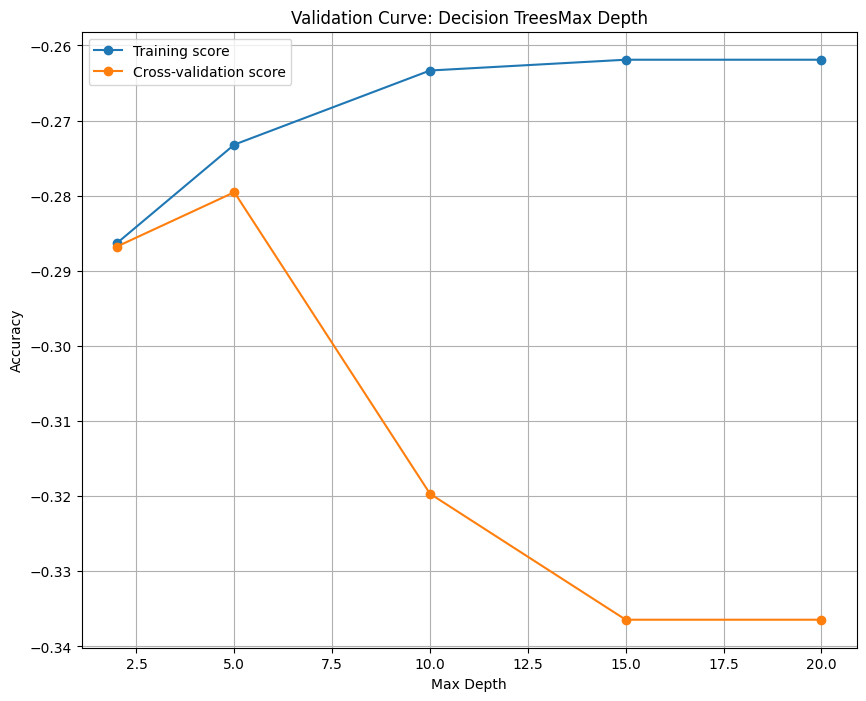

In [30]:
train_scores, test_scores = validation_curve(
    estimator=grid_search_DT.best_estimator_,
    X=X_train_model,
    y=y_train,
    param_name="max_depth",
    param_range=param_distributions['max_depth'],
    cv=5,
    scoring="neg_log_loss",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plot_validation_curve(param_distributions['max_depth'], train_scores, test_scores, model_version='Decision Trees')

0.9021607186210245 0.3643533123028392


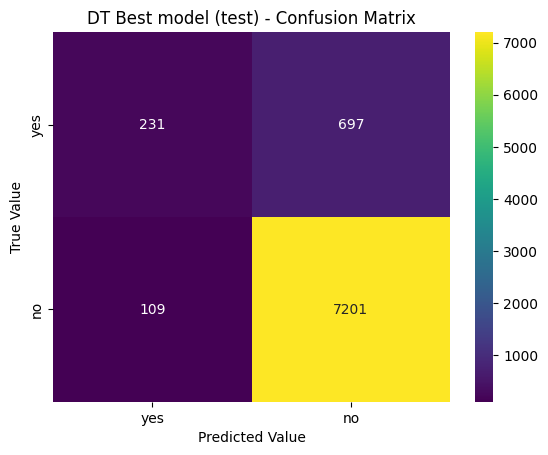

AUCPR:  0.4493273200810764


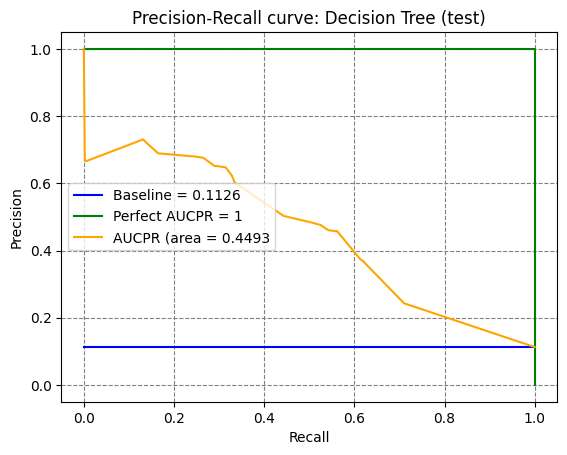

In [31]:
# Final evaluation on test set
yhat_test_DT = grid_search_DT.predict(X_test_model)

accuracy_result = accuracy_score(y_test, yhat_test_DT)
f1_result  = f1_score(y_test, yhat_test_DT)

print(accuracy_result, f1_result)

# Get probabilities for AUCPR curve
yhat_test_DT_proba = grid_search_DT.predict_proba(X_test_model)[:, 1]
cm_test = confusion_matrix(y_test, yhat_test_DT, labels=[1, 0])
plot_confusion_matrix(cm_test, title='DT Best model (test) - Confusion Matrix')

# Get AUCPR curve
auc_result, fig = plot_auc_curve(y_test, yhat_test_DT_proba, model_version='Decision Tree (test)')

# Save metrics
metrics_summary.loc[len(metrics_summary.index)] = ['decision_tree', accuracy_result, f1_result, auc_result]

fig

,feature,importance,model
61,nr.employed_std,0.652161,decision_tree
55,pdays_std,0.137425,decision_tree
59,cons.conf.idx_std,0.062024,decision_tree
60,euribor3m_std,0.051622,decision_tree
51,month=oct,0.022250,decision_tree
...,...,...,...
26,poutcome=failure,0.000000,decision_tree
27,poutcome=nonexistent,0.000000,decision_tree
28,poutcome=success,0.000000,decision_tree
29,default=no,0.000000,decision_tree


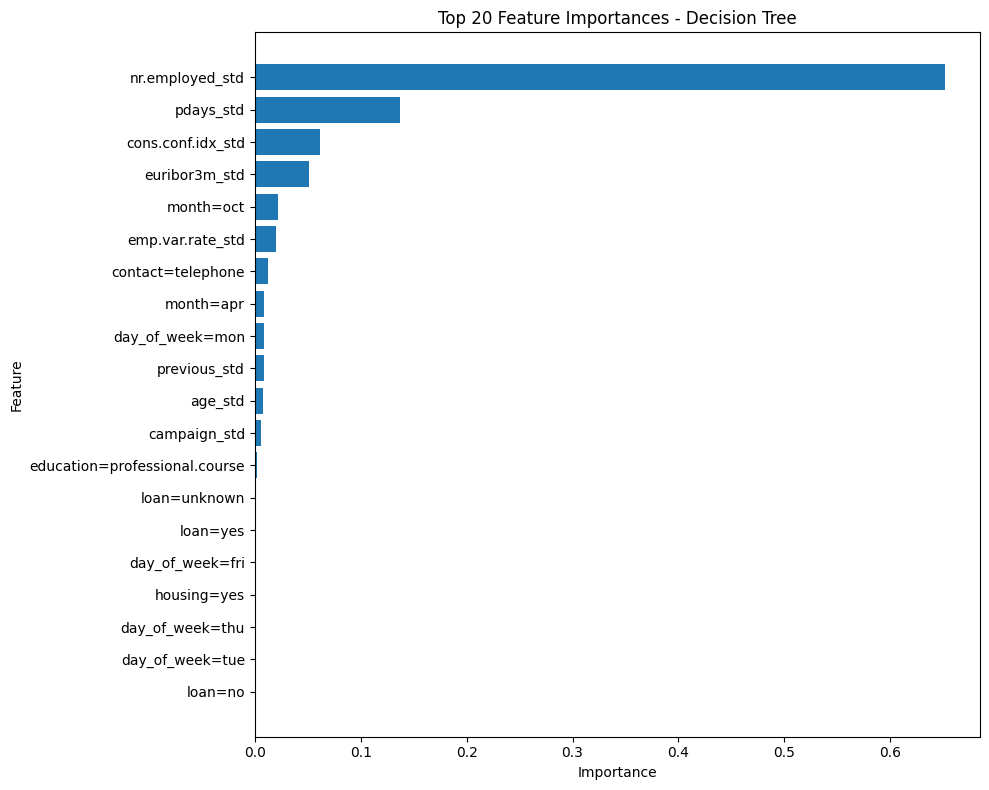

In [32]:
# Get feature importances from the best estimator
feature_importance_dt = pd.DataFrame({'feature':grid_search_DT.best_estimator_.feature_names_in_, 'importance':grid_search_DT.best_estimator_.feature_importances_})
feature_importance_dt.sort_values('importance', ascending=False, inplace=True)
plot_feature_importance(feature_importance_dt, 'Decision Tree', top_n=20)
feature_importance_dt['model'] = 'decision_tree'
feature_importance_summary = pd.concat([feature_importance_summary,feature_importance_dt])
feature_importance_dt

## a. Random Forest - Baseline

We will use Random Forest as the Baseline model. We will perform parameter tuning on depth, minimum samples and regularization.

### Run Random Forest

In [33]:
# Run model and get predictions

# Create base model
rfc = RandomForestClassifier(
    random_state=62
)

param_distributions = {
    'max_depth': [2, 5, 10],
    'min_samples_split':[2, 5, 10, 15],
    'ccp_alpha': [1e-4, 1e-3, 0.01],
    'criterion': ['gini']
}

grid_search_RF = GridSearchCV(
    estimator=rfc,
    param_grid=param_distributions,
    cv=5,
    scoring='neg_log_loss'
)

grid_search_RF.fit(X_train_model, y_train)

# runtime ~ 3 minutes

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=62),
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.01],
                         'criterion': ['gini'], 'max_depth': [2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15]},
             scoring='neg_log_loss')

In [34]:
print("Best Parameters:", grid_search_RF.best_params_)
print("Best CV Score:", grid_search_RF.best_score_)


results = pd.DataFrame(grid_search_RF.cv_results_)
results_dict['Random_forest'] = results[['param_max_depth', 'param_min_samples_split', 'param_ccp_alpha', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

Best Parameters: {'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
Best CV Score: -0.27351060311462383


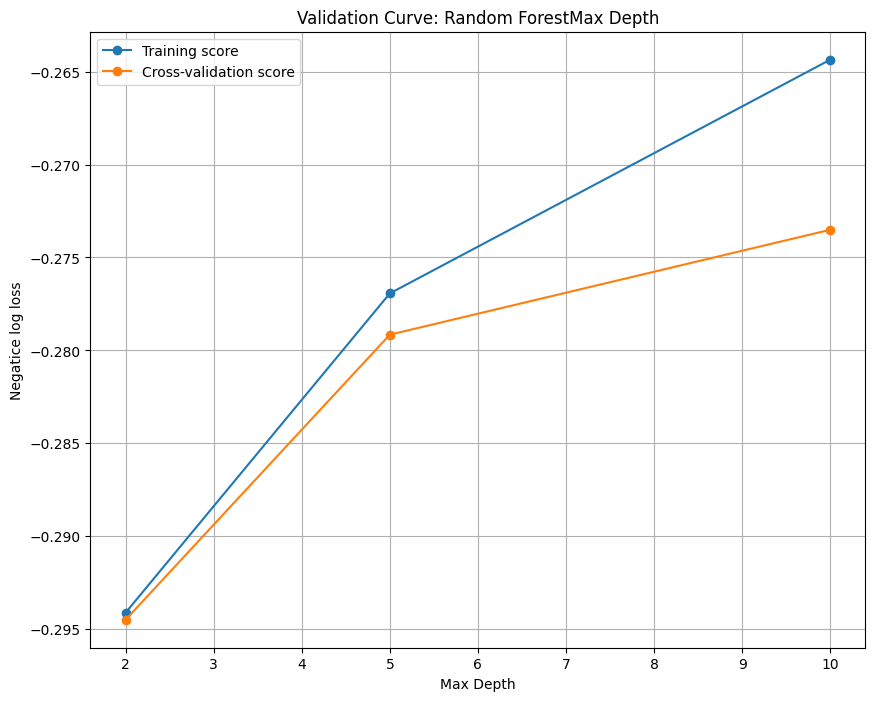

In [35]:
train_scores, test_scores = validation_curve(
    estimator=grid_search_RF.best_estimator_,
    X=X_train_model,
    y=y_train,
    param_name="max_depth",
    param_range=param_distributions['max_depth'],
    cv=5,
    scoring="neg_log_loss",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plot_validation_curve(param_distributions['max_depth'], train_scores, test_scores, model_version='Random Forest', ylabel='Negatice log loss', xlabel='Max Depth')

0.899368778829813 0.3016006739679865


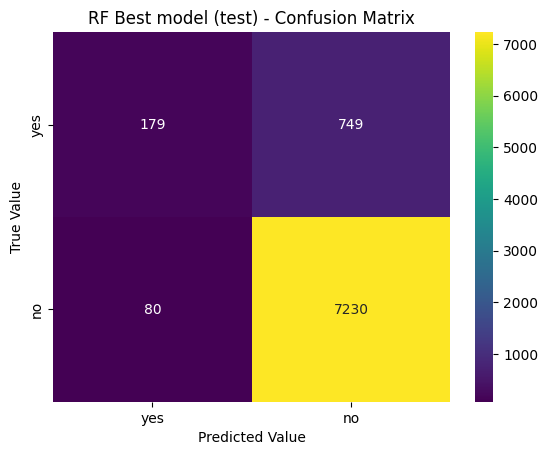

AUCPR:  0.4727209684940654


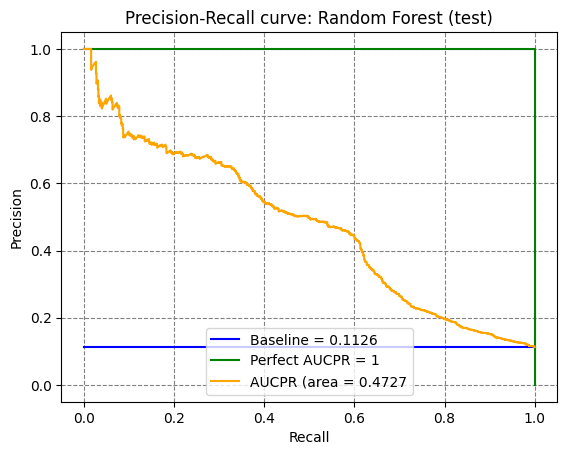

In [36]:
# Final evaluation on test set
yhat_test_RF = grid_search_RF.predict(X_test_model)

accuracy_result = accuracy_score(y_test, yhat_test_RF)
f1_result = f1_score(y_test, yhat_test_RF, pos_label=1)

print(accuracy_result, f1_result)

# Get probabilities for AUCPR curve
yhat_test_RF_proba = grid_search_RF.predict_proba(X_test_model)[:, 1]

# Get confusion matrix
cm_test = confusion_matrix(y_test, yhat_test_RF, labels=[1,0])
plot_confusion_matrix(cm_test, title='RF Best model (test) - Confusion Matrix')

# Get AUCPR curve
auc_result, fig = plot_auc_curve(y_test, yhat_test_RF_proba, model_version='Random Forest (test)')

# Save metrics
metrics_summary.loc[len(metrics_summary.index)] = ['random_forest', accuracy_result, f1_result, auc_result]

fig

,feature,importance,model
61,nr.employed_std,0.170626,random_forest
60,euribor3m_std,0.167677,random_forest
55,pdays_std,0.124788,random_forest
28,poutcome=success,0.090479,random_forest
59,cons.conf.idx_std,0.074869,random_forest
...,...,...,...
2,job=entrepreneur,0.000416,random_forest
17,education=basic.6y,0.000341,random_forest
15,marital=unknown,0.000165,random_forest
20,education=illiterate,0.000087,random_forest


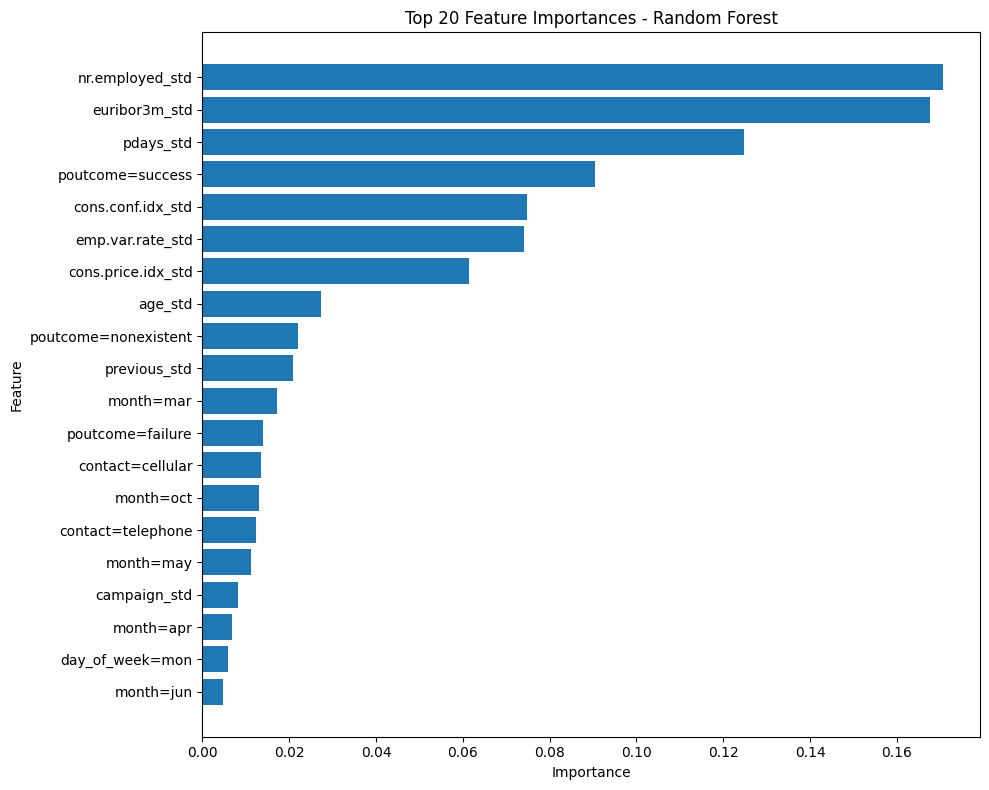

In [37]:
# Get feature importances from the best estimator
feature_importance_rf = pd.DataFrame({'feature':grid_search_RF.best_estimator_.feature_names_in_, 'importance':grid_search_RF.best_estimator_.feature_importances_})
feature_importance_rf.sort_values('importance', ascending=False, inplace=True)
plot_feature_importance(feature_importance_rf, 'Random Forest', top_n=20)
feature_importance_rf['model'] = 'random_forest'
feature_importance_summary = pd.concat([feature_importance_summary,feature_importance_rf])
feature_importance_rf

## b. Boosting Machines

### Run Gradient Boosting Machine

In [38]:
# Run model and get predictions

# Create base model
gbc = GradientBoostingClassifier(
    random_state=62
)

# Use Grid search with maximum iteration = 20
param_distributions = {
    'n_estimators': [20, 50, 100],
    'max_depth': [2, 5, 10],
    'learning_rate':[0.01, 0.1, 0.3],
    'subsample':[0.25, 0.5, 0.75]
}

grid_search_GBM = GridSearchCV(
    estimator=gbc,
    param_grid=param_distributions,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1
)

grid_search_GBM.fit(X_train_model, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=62),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [2, 5, 10], 'n_estimators': [20, 50, 100],
                         'subsample': [0.25, 0.5, 0.75]},
             scoring='neg_log_loss')

In [39]:
print("Best Parameters:", grid_search_GBM.best_params_)
print("Best CV Score:", grid_search_GBM.best_score_)


results = pd.DataFrame(grid_search_GBM.cv_results_)
results_dict['Gradient_Boosting_Machine'] = results[['param_n_estimators','param_max_depth', 'param_learning_rate', 'param_subsample', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.75}
Best CV Score: -0.27386712925111134


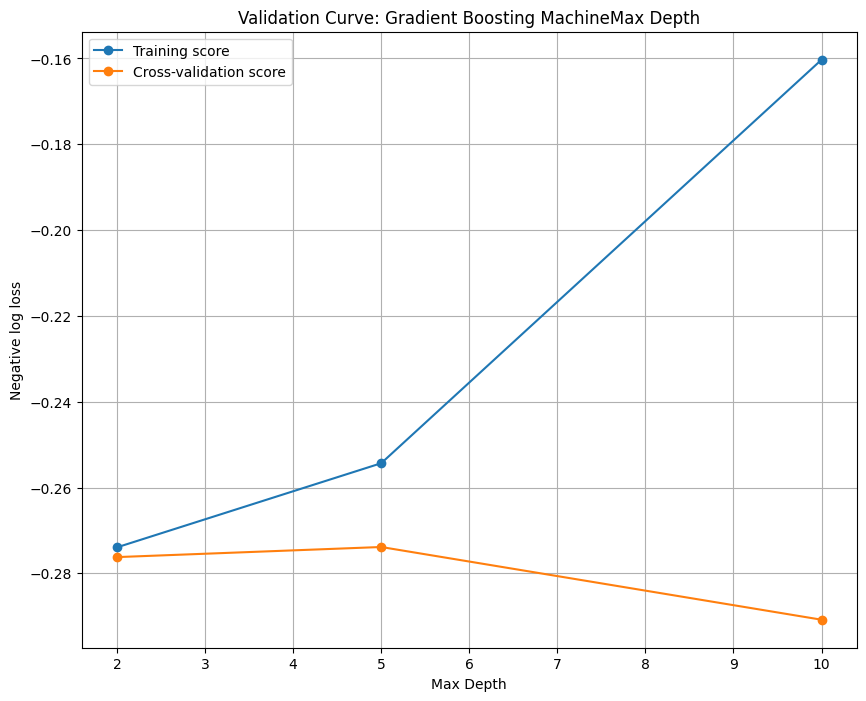

In [40]:
train_scores, test_scores = validation_curve(
    estimator=grid_search_GBM.best_estimator_,
    X=X_train_model,
    y=y_train,
    param_name="max_depth",
    param_range=param_distributions['max_depth'],
    cv=5,
    scoring="neg_log_loss",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plot_validation_curve(param_distributions['max_depth'], train_scores, test_scores, model_version='Gradient Boosting Machine', ylabel='Negative log loss', xlabel='Max Depth')

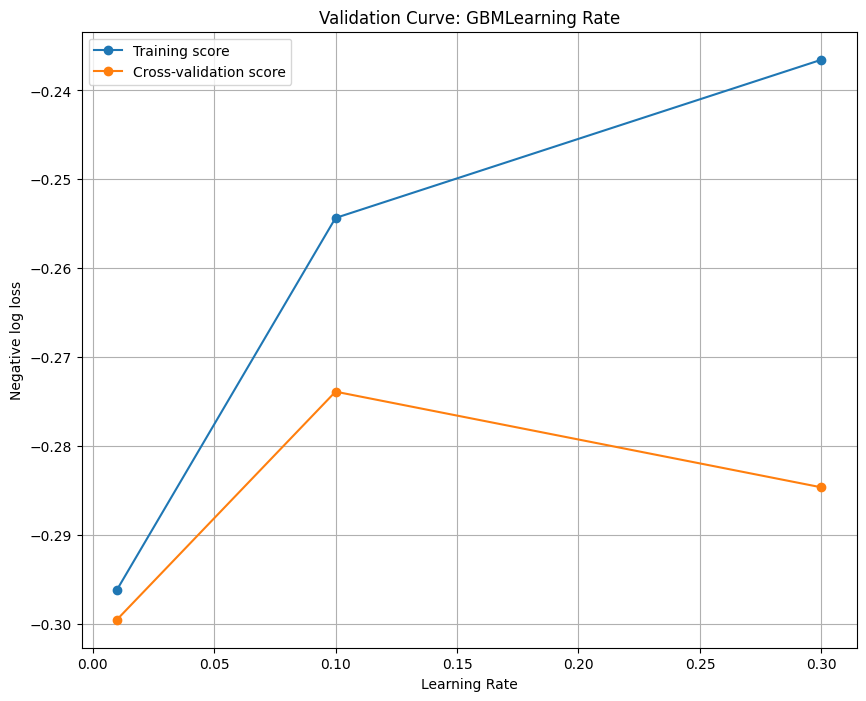

In [41]:
train_scores, test_scores = validation_curve(
    estimator=grid_search_GBM.best_estimator_,
    X=X_train_model,
    y=y_train,
    param_name="learning_rate",
    param_range=param_distributions['learning_rate'],
    cv=5,
    scoring="neg_log_loss",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plot_validation_curve(param_distributions['learning_rate'], train_scores, test_scores, model_version='GBM', ylabel='Negative log loss', xlabel='Learning Rate')

0.9004612770089827 0.36923076923076925


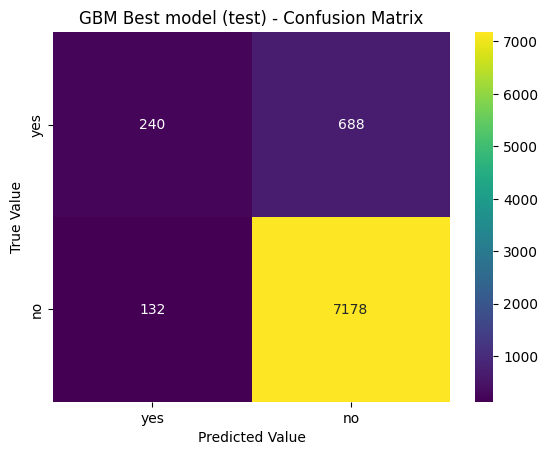

AUCPR:  0.4642415948906399


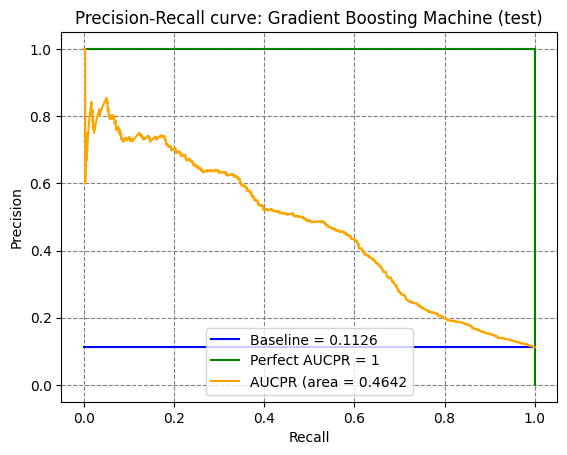

In [42]:
# Final evaluation on test set
yhat_test_GBM = grid_search_GBM.predict(X_test_model)

accuracy_result = accuracy_score(y_test, yhat_test_GBM)
f1_result  = f1_score(y_test, yhat_test_GBM, pos_label=1)

print(accuracy_result, f1_result)

# Get probabilities for AUCPR curve
yhat_test_GBM_proba = grid_search_GBM.predict_proba(X_test_model)[:, 1]

# Get confusion matrix
cm_test = confusion_matrix(y_test, yhat_test_GBM, labels=[1,0])
plot_confusion_matrix(cm_test, title='GBM Best model (test) - Confusion Matrix')

# Get AUCPR curve
auc_result, fig = plot_auc_curve(y_test, yhat_test_GBM_proba, model_version='Gradient Boosting Machine (test)')

# Save metrics
metrics_summary.loc[len(metrics_summary.index)] = ['gradient_boosting_machine', accuracy_result, f1_result, auc_result]

fig

,feature,importance,model
61,nr.employed_std,0.468630,gradient_boosting_machine
60,euribor3m_std,0.098918,gradient_boosting_machine
55,pdays_std,0.088611,gradient_boosting_machine
59,cons.conf.idx_std,0.057125,gradient_boosting_machine
53,age_std,0.054250,gradient_boosting_machine
...,...,...,...
2,job=entrepreneur,0.000652,gradient_boosting_machine
44,month=aug,0.000565,gradient_boosting_machine
5,job=retired,0.000500,gradient_boosting_machine
20,education=illiterate,0.000419,gradient_boosting_machine


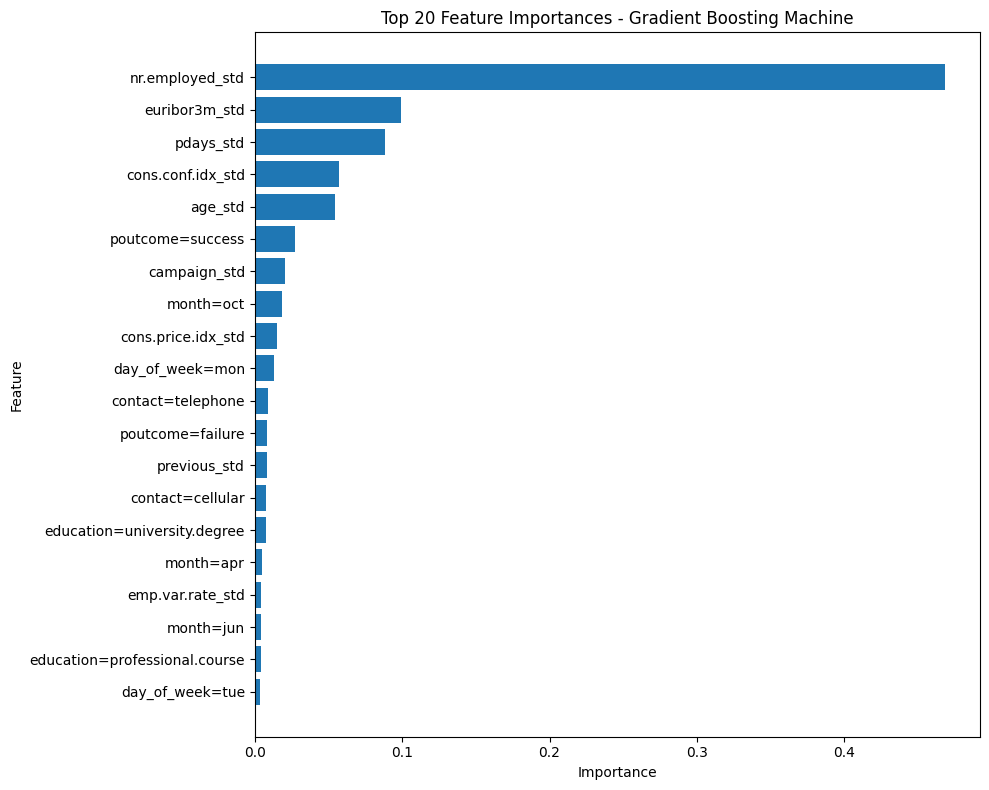

In [43]:
# Get feature importances from the best estimator
feature_importance_gbm = pd.DataFrame({'feature':grid_search_GBM.best_estimator_.feature_names_in_, 'importance':grid_search_GBM.best_estimator_.feature_importances_})
feature_importance_gbm.sort_values('importance', ascending=False, inplace=True)
plot_feature_importance(feature_importance_gbm, 'Gradient Boosting Machine', top_n=20)
feature_importance_gbm['model'] = 'gradient_boosting_machine'
feature_importance_summary = pd.concat([feature_importance_summary,feature_importance_gbm])
feature_importance_gbm

### Run XGBoost

In [44]:
# Initialize XGB model

xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=62,
        n_jobs=-1,
        # early_stopping_rounds=50
    )

param_distributions = {
    'n_estimators': [20, 50, 100],
    'max_depth': [2, 5, 10],
    'learning_rate':[0.01, 0.1, 0.3],
    'subsample':[0.25, 0.5, 0.75],
}

In [45]:
# Grid search for hyperparameter tuning
grid_search_XGB = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_distributions,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1
)

grid_search_XGB.fit(X_train_model, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=62, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [2, 5, 10], 'n_estimators': [20, 50, 100],
                         'subsample': [0.25, 0.5, 0.75]},
             scoring='neg_log_loss')

In [46]:
print("Best Parameters:", grid_search_XGB.best_params_)
print("Best CV Score:", grid_search_XGB.best_score_)

results = pd.DataFrame(grid_search_XGB.cv_results_)
results_dict['XGBoost'] = results[['param_n_estimators','param_max_depth', 'param_learning_rate', 'param_subsample', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.5}
Best CV Score: -0.2722334432215786


In [47]:
# To assess early stopping effect over boosting rounds

X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_model, y_train, test_size=0.2, random_state=62, stratify=y_train)

# Split Train data into 

xgb_model_best = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=62,
        n_jobs=-1,
        early_stopping_rounds=50,
        param_distributions=grid_search_XGB.best_params_
    )

# Set up evaluation set
eval_set = [(X_train_xgb, y_train_xgb),(X_val_xgb, y_val_xgb)] 

xgb_model_best.fit(X_train_xgb, y_train_xgb, eval_set=eval_set)

[0]	validation_0-logloss:0.31839	validation_1-logloss:0.32077
[1]	validation_0-logloss:0.29579	validation_1-logloss:0.29976
[2]	validation_0-logloss:0.28207	validation_1-logloss:0.28810
[3]	validation_0-logloss:0.27319	validation_1-logloss:0.28120
[4]	validation_0-logloss:0.26772	validation_1-logloss:0.27733
[5]	validation_0-logloss:0.26396	validation_1-logloss:0.27505
[6]	validation_0-logloss:0.26115	validation_1-logloss:0.27375
[7]	validation_0-logloss:0.25839	validation_1-logloss:0.27302
[8]	validation_0-logloss:0.25697	validation_1-logloss:0.27271
[9]	validation_0-logloss:0.25522	validation_1-logloss:0.27280
[10]	validation_0-logloss:0.25322	validation_1-logloss:0.27269
[11]	validation_0-logloss:0.25225	validation_1-logloss:0.27260
[12]	validation_0-logloss:0.25143	validation_1-logloss:0.27222
[13]	validation_0-logloss:0.25069	validation_1-logloss:0.27257


/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:12:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "param_distributions" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-logloss:0.24901	validation_1-logloss:0.27277
[15]	validation_0-logloss:0.24796	validation_1-logloss:0.27277
[16]	validation_0-logloss:0.24717	validation_1-logloss:0.27288
[17]	validation_0-logloss:0.24670	validation_1-logloss:0.27295
[18]	validation_0-logloss:0.24575	validation_1-logloss:0.27299
[19]	validation_0-logloss:0.24557	validation_1-logloss:0.27305
[20]	validation_0-logloss:0.24490	validation_1-logloss:0.27282
[21]	validation_0-logloss:0.24428	validation_1-logloss:0.27281
[22]	validation_0-logloss:0.24332	validation_1-logloss:0.27281
[23]	validation_0-logloss:0.24294	validation_1-logloss:0.27293
[24]	validation_0-logloss:0.24206	validation_1-logloss:0.27307
[25]	validation_0-logloss:0.24078	validation_1-logloss:0.27362
[26]	validation_0-logloss:0.24059	validation_1-logloss:0.27368
[27]	validation_0-logloss:0.23923	validation_1-logloss:0.27406
[28]	validation_0-logloss:0.23812	validation_1-logloss:0.27474
[29]	validation_0-logloss:0.23679	validation_1-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None,
              param_distributions={'learning_rate': 0.1, 'max_depth': 5,
                                   'n_estimators': 50, 'subsample': 0.5}, ...)

In [48]:
# Get results for XGBoost model with set early stopping and eval_set
results_es = xgb_model_best.evals_result()

# Transform into negative log loss for comparisons
results_es['validation_0']['neglogloss'] = [i*-1 for i in  results_es['validation_0']['logloss']]
results_es['validation_1']['neglogloss'] = [i*-1 for i in results_es['validation_1']['logloss']]

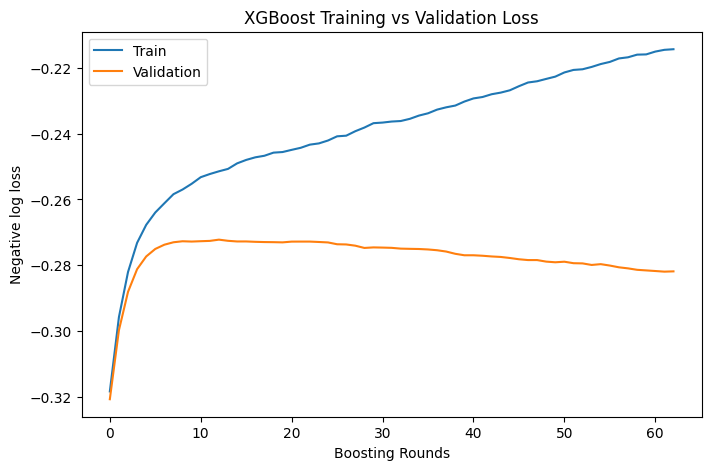

In [49]:
epochs = len(results_es['validation_0']['neglogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, results_es['validation_0']['neglogloss'], label='Train')
plt.plot(x_axis, results_es['validation_1']['neglogloss'], label='Validation')
plt.xlabel('Boosting Rounds')
plt.ylabel('Negative log loss')
plt.title('XGBoost Training vs Validation Loss')
plt.legend()
plt.show()

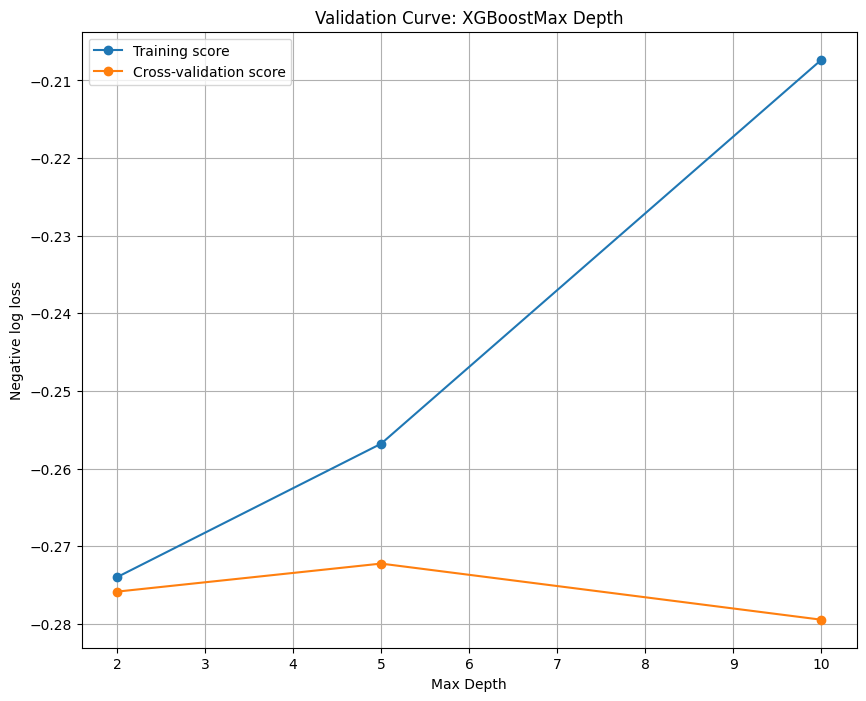

In [50]:
train_scores, test_scores = validation_curve(
    estimator=grid_search_XGB.best_estimator_,
    X=X_train_model,
    y=y_train,
    param_name="max_depth",
    param_range=param_distributions['max_depth'],
    cv=5,
    scoring="neg_log_loss",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plot_validation_curve(param_distributions['max_depth'], train_scores, test_scores, model_version='XGBoost', ylabel='Negative log loss', xlabel='Max Depth')

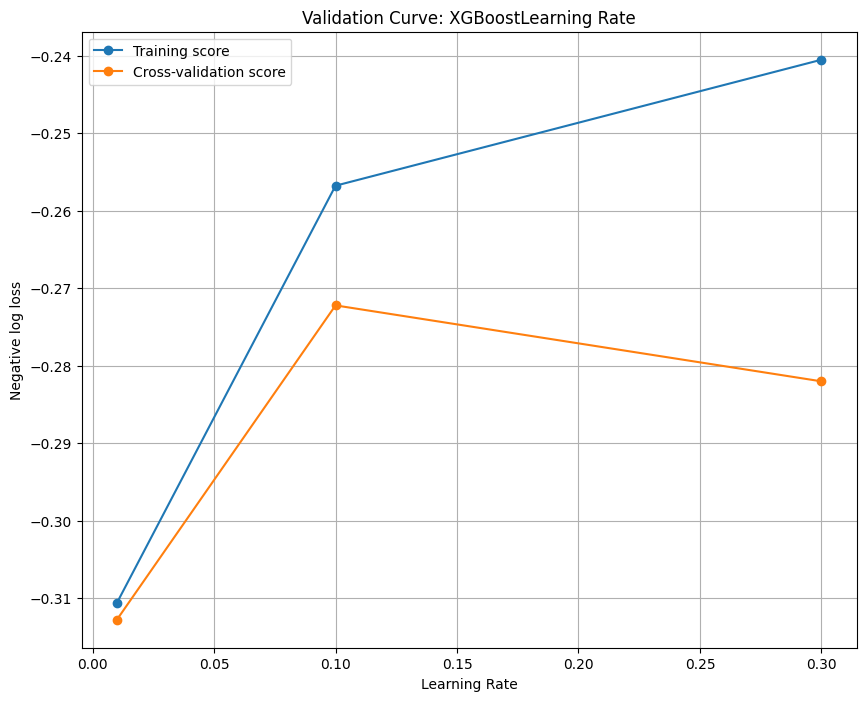

In [51]:
train_scores, test_scores = validation_curve(
    estimator=grid_search_XGB.best_estimator_,
    X=X_train_model,
    y=y_train,
    param_name="learning_rate",
    param_range=param_distributions['learning_rate'],
    cv=5,
    scoring="neg_log_loss",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plot_validation_curve(param_distributions['learning_rate'], train_scores, test_scores, model_version='XGBoost', ylabel='Negative log loss', xlabel='Learning Rate')

0.9011896091284293 0.34775641025641024


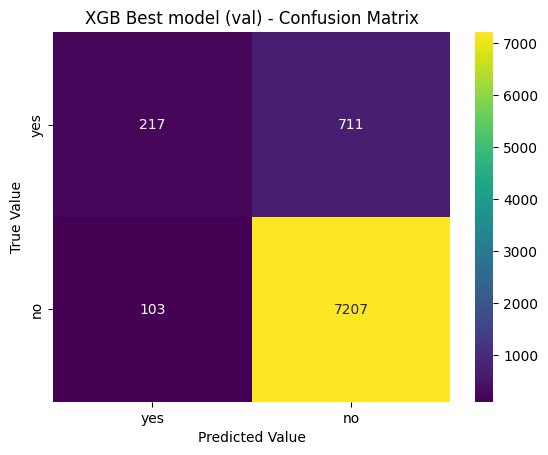

AUCPR:  0.47432767913588453


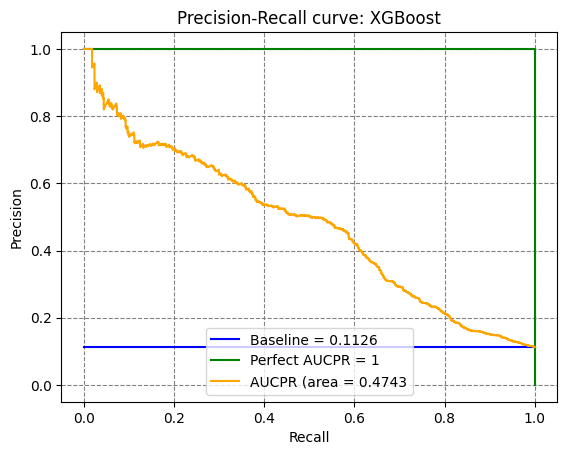

In [52]:
# Visualize results
yhat_test_XGB = grid_search_XGB.predict(X_test_model)

accuracy_result = accuracy_score(y_test, yhat_test_XGB)
f1_result  = f1_score(y_test, yhat_test_XGB, pos_label=1)

print(accuracy_result, f1_result)

# Get probabilities for AUCPR curve
yhat_test_XGB_proba = grid_search_XGB.predict_proba(X_test_model)[:, 1]

# Get confusion matrix
cm_test = confusion_matrix(y_test, yhat_test_XGB, labels=[1,0])
plot_confusion_matrix(cm_test, title='XGB Best model (val) - Confusion Matrix')

# Get AUCPR curve
auc_result, fig = plot_auc_curve(y_test, yhat_test_XGB_proba, model_version='XGBoost')

# Save metrics
metrics_summary.loc[len(metrics_summary.index)] = ['xgboost', accuracy_result, f1_result, auc_result]

fig

,feature,importance,model
61,nr.employed_std,0.467924,xgboost
57,emp.var.rate_std,0.051347,xgboost
28,poutcome=success,0.048033,xgboost
43,month=apr,0.029915,xgboost
59,cons.conf.idx_std,0.027228,xgboost
...,...,...,...
36,loan=unknown,0.000000,xgboost
30,default=unknown,0.000000,xgboost
25,contact=telephone,0.000000,xgboost
20,education=illiterate,0.000000,xgboost


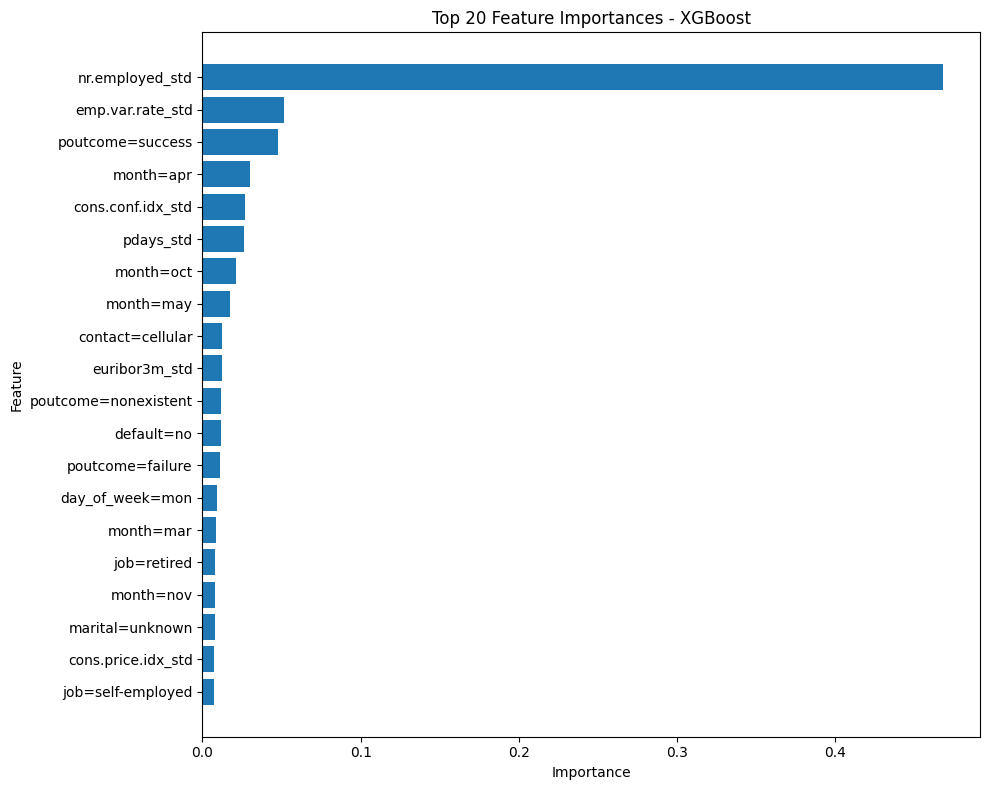

In [53]:
# Get feature importances from the best estimator
feature_importance_xgb = pd.DataFrame({'feature':grid_search_XGB.best_estimator_.feature_names_in_, 'importance':grid_search_XGB.best_estimator_.feature_importances_})
feature_importance_xgb.sort_values('importance', ascending=False, inplace=True)
plot_feature_importance(feature_importance_xgb, 'XGBoost', top_n=20)
feature_importance_xgb['model'] = 'xgboost'
feature_importance_summary = pd.concat([feature_importance_summary,feature_importance_xgb])
feature_importance_xgb

# Model Evaluation

In [54]:
# Output results to excel for easier review
with pd.ExcelWriter(folder_path+result_filename) as writer:
    for sheet_name, result_df in results_dict.items():
        result_df.to_excel(writer, sheet_name = sheet_name, index=False)
    metrics_summary.to_excel(writer, sheet_name='metrics_summary', index=False)
    feature_importance_summary.to_excel(writer, sheet_name='feature_importance_summary', index=False)

writer.close()

/Users/yelene/Desktop/Grad school/Columbia/Classes/Coding/venv/lib/python3.8/site-packages/xlsxwriter/workbook.py:404: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
